### Importação de bibliotecas python

In [1]:
import os
import json
import pickle
import neptune
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

### Importação de módulos do projeto

In [2]:
os.chdir("..")

In [3]:
from calysto.feature_engineering import Engineering

### Load Settings

In [4]:
feature_params = json.load(open("settings/dataprep_improved.json", "r"))

### Read Data

In [5]:
train = pd.read_csv("data/train.csv")

In [6]:
test = pd.read_csv("data/test.csv")

### Exploratory Analysis

In [7]:
!cat data/data_description.txt

MSSubClass: Identifies the type of dwelling involved in the sale.	

        20	1-STORY 1946 & NEWER ALL STYLES
        30	1-STORY 1945 & OLDER
        40	1-STORY W/FINISHED ATTIC ALL AGES
        45	1-1/2 STORY - UNFINISHED ALL AGES
        50	1-1/2 STORY FINISHED ALL AGES
        60	2-STORY 1946 & NEWER
        70	2-STORY 1945 & OLDER
        75	2-1/2 STORY ALL AGES
        80	SPLIT OR MULTI-LEVEL
        85	SPLIT FOYER
        90	DUPLEX - ALL STYLES AND AGES
       120	1-STORY PUD (Planned Unit Development) - 1946 & NEWER
       150	1-1/2 STORY PUD - ALL AGES
       160	2-STORY PUD - 1946 & NEWER
       180	PUD - MULTILEVEL - INCL SPLIT LEV/FOYER
       190	2 FAMILY CONVERSION - ALL STYLES AND AGES

MSZoning: Identifies the general zoning classification of the sale.
		
       A	Agriculture
       C	Commercial
       FV	Floating Village Residential
       I	Industrial
       RH	Residential High Density
       RL	Residential Low Density
       RP	Residential Low Density Park 
       RM

### Análise descritiva

In [8]:
X = train[list(train.columns)]
y = train[["SalePrice"]]

In [9]:
from sklearn.model_selection import train_test_split

In [10]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=1903)

In [11]:
X_train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
788,789,20,RM,50.0,6000,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2008,WD,Normal,107900
903,904,20,RL,50.0,14859,Pave,NaN,IR1,HLS,AllPub,...,0,NaN,NaN,NaN,0,8,2006,New,Partial,240000
1297,1298,180,RM,35.0,3675,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,6,2006,New,Partial,140000
7,8,60,RL,NaN,10382,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,Shed,350,11,2009,WD,Normal,200000
649,650,180,RM,21.0,1936,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,12,2007,WD,Normal,84500


In [54]:
variavel_analise =  "Neighborhood"

In [55]:
DescribeCount = test.\
    fillna('missing').\
    groupby([variavel_analise])['Id'].\
    describe()[['count']].\
    apply(lambda x: round(x, 1)).\
    reset_index()

DescribeCount

,Neighborhood,count
0,Blmngtn,11.0
1,Blueste,8.0
2,BrDale,14.0
3,BrkSide,50.0
4,ClearCr,16.0
5,CollgCr,117.0
6,Crawfor,52.0
7,Edwards,94.0
8,Gilbert,86.0
9,IDOTRR,56.0


In [56]:
DescribeCount = X_train .\
    fillna('missing').\
    groupby([variavel_analise])['SalePrice'].\
    describe().\
    apply(lambda x: round(x, 1)).\
    reset_index()

DescribeCount

,Neighborhood,count,mean,std,min,25%,50%,75%,max
0,Blmngtn,13.0,195760.8,29024.2,160200.0,175900.0,191000.0,213490.0,264561.0
1,Blueste,2.0,137500.0,19091.9,124000.0,130750.0,137500.0,144250.0,151000.0
2,BrDale,15.0,103493.3,14243.1,83000.0,90500.0,106000.0,115500.0,125000.0
3,BrkSide,46.0,123186.4,40699.8,39300.0,100000.0,124000.0,136850.0,223500.0
4,ClearCr,24.0,217037.5,50788.3,130000.0,186875.0,205500.0,247300.0,328000.0
5,CollgCr,119.0,201049.3,51329.0,112500.0,162870.0,197900.0,230000.0,424870.0
6,Crawfor,40.0,211021.5,71846.0,90350.0,161875.0,208812.0,236000.0,392500.0
7,Edwards,72.0,127487.1,42059.1,58500.0,99975.0,124250.0,146300.0,274970.0
8,Gilbert,64.0,192367.8,37735.0,141000.0,174000.0,181067.0,192355.0,377500.0
9,IDOTRR,29.0,99106.2,33583.8,34900.0,81000.0,102776.0,120500.0,169500.0


In [57]:
X_train[variavel_analise].fillna('missing').unique()

array(['OldTown', 'Gilbert', 'Edwards', 'NWAmes', 'MeadowV', 'NAmes',
       'Timber', 'ClearCr', 'IDOTRR', 'Blmngtn', 'Sawyer', 'Crawfor',
       'CollgCr', 'Somerst', 'BrkSide', 'NridgHt', 'NPkVill', 'Mitchel',
       'NoRidge', 'BrDale', 'StoneBr', 'SawyerW', 'Veenker', 'SWISU',
       'Blueste'], dtype=object)

In [58]:
exp_data = X_train[["Id", variavel_analise, "SalePrice"]].fillna("missing")

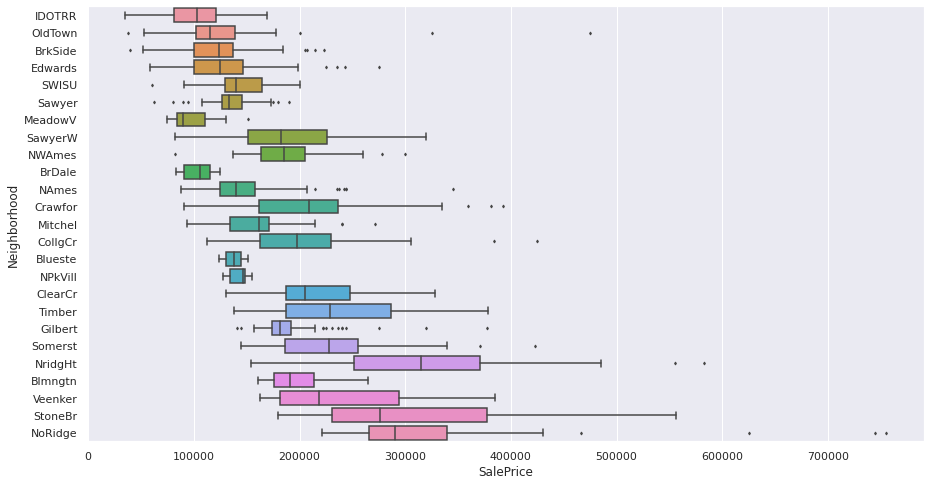

In [59]:
plt.figure(figsize=(15,8))
ax = sns.boxplot(x="SalePrice", y=variavel_analise, 
                 data=exp_data.sort_values("SalePrice"),
                 orient="h", fliersize=2)

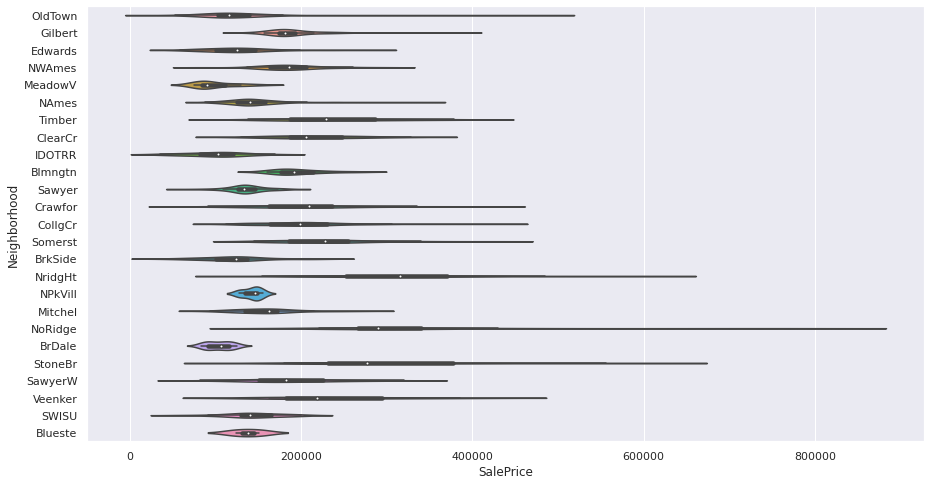

In [60]:
plt.figure(figsize=(15,8))
ax = sns.violinplot(x="SalePrice", y=variavel_analise, 
                 data=exp_data,
                 orient="h", fliersize=2)

In [61]:
import scipy

IndexError: list index out of range

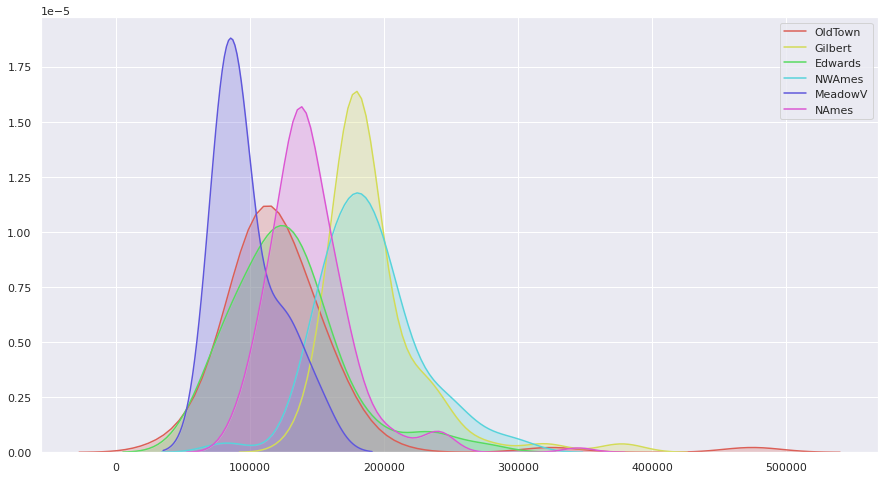

In [62]:
plt.figure(figsize=(15,8))
i = 0
for classe in exp_data[variavel_analise].unique():
    d = pd.DataFrame(exp_data.loc[exp_data[variavel_analise] == classe, "SalePrice"])
    d.rename(columns={'SalePrice': classe}, inplace=True)
    p1=sns.kdeplot(d[classe],
                   shade=True, 
                   color=sns.color_palette("hls", 12)[i])
    i=i+2

In [53]:
X_train.loc[X_train["Id"] == 124]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
123,124,120,RL,55.0,7892,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,3,2008,WD,Normal,153900
